# Axelrod Culture Model – Phase-Plot Notebook

This notebook implements the Axelrod model of cultural dissemination, and explores the phase space of the number of traits \(q\) vs. parameter \(B\) (or another parameter of interest, such as density or feature count) by running many simulations and generating a heatmap of normalized number of culture domains in the absorbing state.

---

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from tqdm import tqdm
import multiprocessing as mp
from joblib import Parallel, delayed


In [14]:
class CultureAgent(Agent):
    def __init__(self, unique_id, model, features, q):
        super().__init__(unique_id, model)
        # features: list of length F, each trait ∈ {0,…,q−1}
        self.features = features
        self.q = q

    def similarity(self, other):
        return sum(1 for a,b in zip(self.features, other.features) if a==b) / len(self.features)

    def step(self):
        neighbours = self.model.grid.get_neighbors(self.pos, moore=False, include_center=False)
        if not neighbours:
            return  # skip this turn, no interaction possible

        neighbour = random.choice(neighbours)
        sim = self.similarity(neighbour)
        if sim > 0 and random.random() < sim:
            diffs = [i for i,(a,b) in enumerate(zip(self.features, neighbour.features)) if a!=b]
            if diffs:
                i = random.choice(diffs)
                self.features[i] = neighbour.features[i]

In [15]:
class AxelrodModel(Model):
    def __init__(self, width, height, N, F, q, B):
        super().__init__()
        self.grid = MultiGrid(width, height, torus=False)
        self.schedule = RandomActivation(self)
        self.F = F
        self.q = q
        self.B = B
        # create agents
        for i in range(N):
            x = random.randrange(width)
            y = random.randrange(height)
            feats = [random.randrange(q) for _ in range(F)]
            a = CultureAgent(i, self, feats, q)
            self.grid.place_agent(a, (x,y))
            self.schedule.add(a)
        self.datacollector = DataCollector(
            model_reporters={"NumCultures": lambda m: self.count_culture_domains()},
            agent_reporters={}
        )

    def count_culture_domains(self):
        # simple method: count distinct feature‐vectors among agents
        feats = [tuple(agent.features) for agent in self.schedule.agents]
        return len(set(feats))

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self)

    def run_until_absorbed(self, max_steps=10000):
        for step in range(max_steps):
            active_agents = [a for a in self.schedule.agents if len(self.grid.get_neighbors(a.pos, moore=False, include_center=False)) > 0]
            if not active_agents:
                break
            self.step()
        return self.count_culture_domains()











































































































































































































































































Running simulations: 100%|██████████| 3190/3190 [09:35<00:00,  5.54it/s]


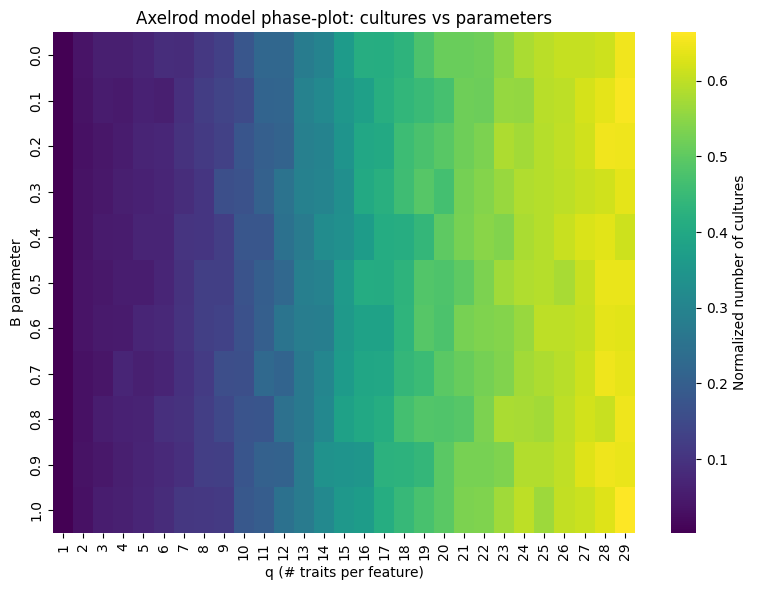

In [20]:
# --- Simulation parameters ---
qs = np.arange(1, 30, 1)       # trait diversity
Bs = np.arange(0.0, 1.1, 0.1)  # placeholder bias parameter
runs_per_cell = 10
max_steps = 2000
width, height, N, F = 20, 20, 400, 5


# --- Function to run one simulation ---
def run_one_simulation(B, q, max_steps):
    try:
        m = AxelrodModel(width=width, height=height, N=N, F=F, q=q, B=B)
        num_cultures = m.run_until_absorbed(max_steps=max_steps)
        living_agents = len(m.schedule.agents)
        if living_agents == 0:
            num_cultures = 0
        return num_cultures
    except Exception:
        return 0


# --- Create all parameter combinations ---
tasks = [(B, q) for B in Bs for q in qs for _ in range(runs_per_cell)]

# --- Run in parallel with progress bar ---
results = Parallel(n_jobs=mp.cpu_count()-2, backend="loky")(
    delayed(run_one_simulation)(B, q, max_steps)
    for B, q in tqdm(tasks, desc="Running simulations")
)

# --- Reshape results into 3D array [B, q, runs] ---
results = np.array(results).reshape(len(Bs), len(qs), runs_per_cell)
heat = np.mean(results, axis=2) / N  # normalize by population size

# --- Plot heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(
    heat,
    xticklabels=qs,
    yticklabels=np.round(Bs, 2),
    cmap="viridis",
    cbar_kws={'label': 'Normalized number of cultures'}
)
plt.xlabel("q (# traits per feature)")
plt.ylabel("B parameter")
plt.title("Axelrod model phase-plot: cultures vs parameters")
plt.tight_layout()
plt.show()



















































































































































































































































Running simulations (varying q & F): 100%|██████████| 2900/2900 [09:09<00:00,  5.28it/s]


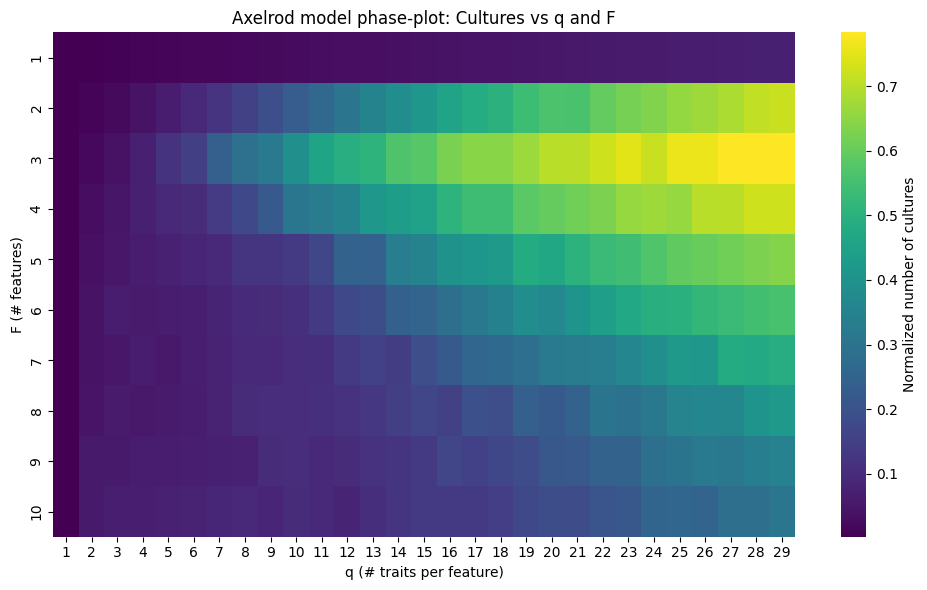

In [21]:
# --- Simulation parameters ---
qs = np.arange(1, 30, 1)       # number of traits per feature
Fs = np.arange(1, 11, 1)       # number of features
B = 0.5                        # fixed bias parameter
runs_per_cell = 10
max_steps = 2000
width, height, N = 20, 20, 400

# --- Function to run one simulation ---
def run_one_simulation(F, q, max_steps):
    try:
        m = AxelrodModel(width=width, height=height, N=N, F=F, q=q, B=B)
        num_cultures = m.run_until_absorbed(max_steps=max_steps)
        living_agents = len(m.schedule.agents)
        if living_agents == 0:
            num_cultures = 0
        return num_cultures
    except Exception:
        return 0

# --- Create all parameter combinations ---
tasks = [(F, q) for F in Fs for q in qs for _ in range(runs_per_cell)]

# --- Run in parallel with progress bar ---
results = Parallel(n_jobs=mp.cpu_count()-2, backend="loky")(
    delayed(run_one_simulation)(F, q, max_steps)
    for F, q in tqdm(tasks, desc="Running simulations (varying q & F)")
)

# --- Reshape results into 3D array [F, q, runs] ---
results = np.array(results).reshape(len(Fs), len(qs), runs_per_cell)
heat = np.mean(results, axis=2) / N  # normalize by population size

# --- Plot heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(
    heat,
    xticklabels=qs,
    yticklabels=Fs,
    cmap="viridis",
    cbar_kws={'label': 'Normalized number of cultures'}
)
plt.xlabel("q (# traits per feature)")
plt.ylabel("F (# features)")
plt.title("Axelrod model phase-plot: Cultures vs q and F")
plt.tight_layout()
plt.show()